In [ ]:
#in terminal:
# source activate stan3.6.6
# conda install numpy cython matplotlib scipy pandas pystan -c conda-forge
# python

In [1]:
#conda install ipykernel
import numpy as np
import statsmodels
import pandas as pd
import pystan #
from scipy.stats import norm, uniform

In [2]:
Auction = pd.read_csv("/Users/Sou/Desktop/Thesis/PyStan/Auction.csv") #Pandas doesn't work well
#with Pystan. Need to convert

In [3]:
#Hard Coded Parameters
np.random.seed(12345)
Nobs= len(Auction['SalesUSD'])
NGroups= Auction['SiteID'].nunique()

In [4]:
#Need to map SiteID categories to a numeric vector
Auction.SiteID = Auction.SiteID.str.strip()
SiteID_num = Auction.SiteID.unique()
SiteIDCount = len(SiteID_num)

SiteID_lookup = dict(zip(SiteID_num, range(len(SiteID_num))))
SiteID= Auction['SiteID'] = Auction.SiteID.replace(SiteID_lookup).values

In [5]:
SiteCount = Auction.groupby(['SiteID']).size().reset_index(name='counts')

In [ ]:
#store the counts in each site under a vector
SiteCount

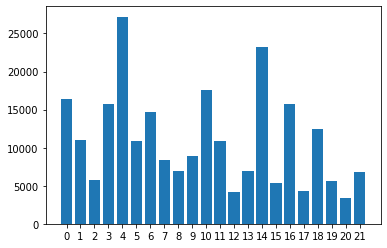

In [9]:
#Bar Chart
import matplotlib.pyplot as plt
x_values = np.transpose(SiteCount['SiteID'])
y_values = np.transpose(SiteCount['counts'])
y_axis = np.arange(len(x_values))
plt.bar(y_axis,y_values)
plt.xticks(y_axis, x_values)
plt.show() #need to expand to make it less cluttered. Also add click over values
#To print, use matplotlib
#matplotlib.pyplot.show()

In [ ]:

random_intercepts = """
data {
  int<lower=0> NGroups; 
  int<lower=0> Nobs; 
  int<lower=1,upper=NGroups> SiteID[Nobs];
  vector[Nobs] LEstimateUSD;
  vector[Nobs] y;
} 
parameters {
  vector[NGroups] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[Nobs] y_hat;

  for (i in 1:Nobs)
    y_hat[i] <- a[SiteID[i]] + LEstimateUSD[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  b ~ normal(0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

model_data = { 'Nobs': Nobs, #242339
               'NGroups': NGroups, #22
               'SiteID': SiteID+1,
               'LEstimateUSD': Auction['LEstimateUSD'].values,
               'y': Auction['SalesUSD'].values }

In [ ]:
randomInterModel= pystan.stan(model_code=random_intercepts, data=model_data, iter=1000, chains=4)
#depreciation of one step in older versions!

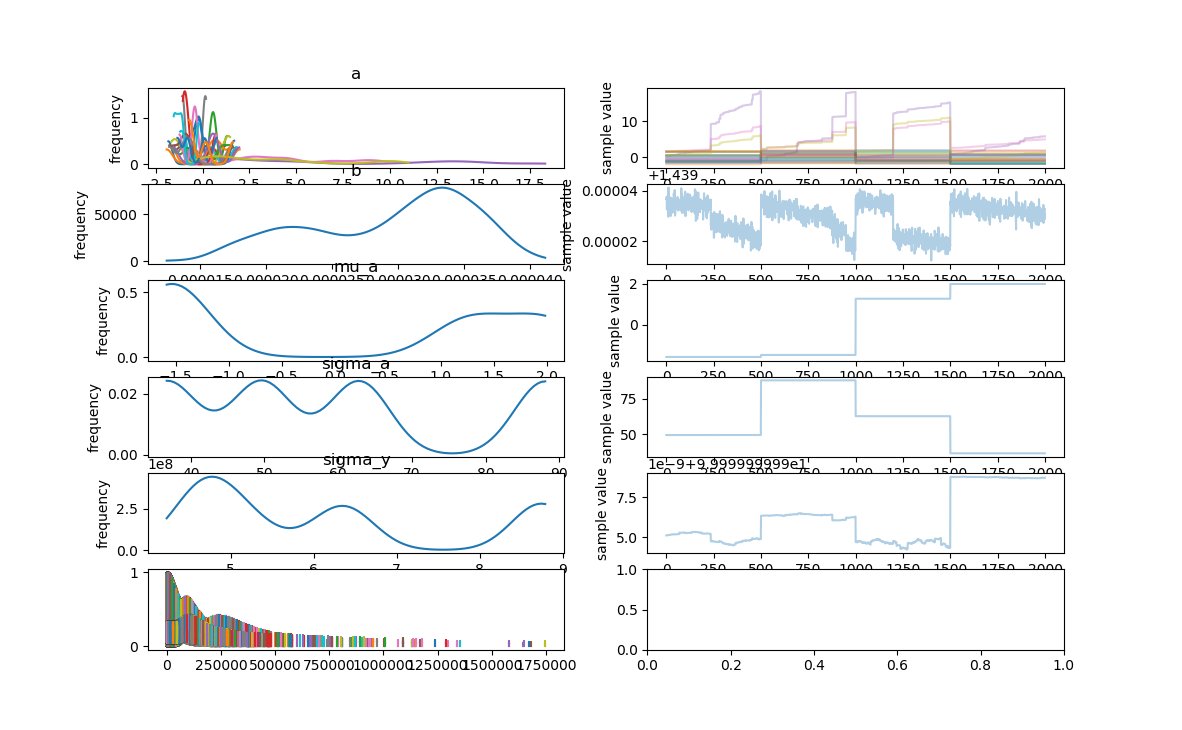

In [10]:
from IPython.display import Image
Image(filename='/Users/Sou/Desktop/RandomInterModel.png')

In [ ]:
#Extending the Linear Model Faraway One-Way Factor ANOVA Using Uniformative Priors
OneWayANOVA_intercepts = """
data {
  int<lower=0> NGroups; 
  int<lower=0> Nobs; 
  int<lower=1,upper=NGroups> SiteID[Nobs];
  vector[Nobs] y;
} 
parameters{
  vector[NGroups] eta;
  real mu;
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_epsilon;
}
transformed parameters{
  vector[NGroups] a;
  vector[Nobs] yhat;
  
  a <- mu + sigma_alpha*eta;
  
  for (i in 1: Nobs)
   yhat[i] <- a[SiteID[i]];
}
model { 
        eta ~ normal(0,1);
        y ~ normal(yhat, sigma_epsilon);
}
"""
ANOVAmodel_data = { 'Nobs': Nobs, #242339
               'NGroups': NGroups, #22
               'SiteID': SiteID+1,
               'y': Auction['SalesUSD'].values }

In [ ]:
OneWay = pystan.stan(model_code=OneWayANOVA_intercepts, data= ANOVAmodel_data, iter=1000, chains=4)

In [ ]:
OneWay.plot()

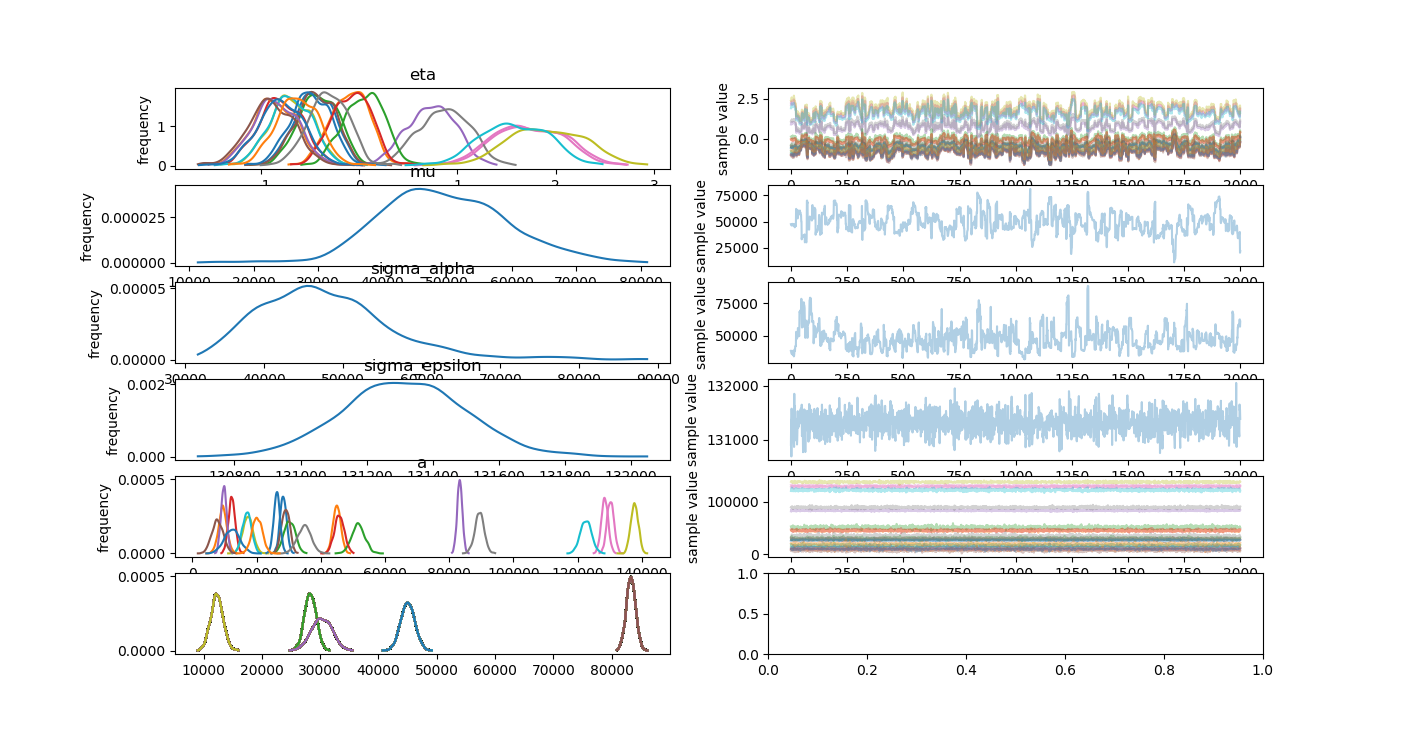

In [13]:
from IPython.display import Image
Image(filename='/Users/Sou/Desktop/OneWayANOVA-Bayesian.png')